In [233]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


from utils import run_and_cache
from TSTtrainer import  TimeSeriesTransformer, load_dataset

In [234]:
torch.manual_seed(123)
np.random.seed(123)

In [235]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [236]:
ACTIVATION_TENSOR = None

In [237]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_lambda=1e-3):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.sparsity_lambda = sparsity_lambda

    def forward(self, x):
        h = F.relu(self.encoder(x))
        x_hat = self.decoder(h)
        return x_hat, h
    
    def loss(self, x, x_hat, h):
        reconstruction_loss = F.mse_loss(x_hat, x)
        sparsity_penalty = self.sparsity_lambda * torch.sum(torch.abs(h))
        return reconstruction_loss + sparsity_penalty

In [238]:
MODEL_PATH = "TST_japanesevowels.pth"
DATASET_NAME = "JapaneseVowels"
LAYER_TARGETS = ["transformer_encoder.layers.0.linear2"]

In [239]:
train_loader, test_loader = load_dataset(DATASET_NAME, batch_size=4)

full_train_inputs = []
full_train_labels = []
for x, y in train_loader:
    full_train_inputs.append(x)
    full_train_labels.append(y)

train_batch = torch.cat(full_train_inputs).to(DEVICE)  # (N, seq_len, channels)
label_batch = torch.cat(full_train_labels)             # (N,)

train_labels = label_batch
seq_len, channels = train_batch.shape[1], train_batch.shape[2]
num_classes = int(train_labels.max().item()) + 1

model = TimeSeriesTransformer(
    input_dim=channels,
    num_classes=num_classes,
    seq_len=seq_len
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()

In [275]:
cache = run_and_cache(model, train_batch, targets=LAYER_TARGETS)
activations = list(cache.values())[0]
ACTIVATION_TENSOR = activations.view(-1, activations.size(-1)).cpu()
total_timesteps, feature_dim = ACTIVATION_TENSOR.shape

# you know each instance is seq_len long
seq_len = train_batch.shape[1]    # e.g. 25

# compute how many instances you have
num_instances = total_timesteps // seq_len
assert num_instances * seq_len == total_timesteps, \
       "timesteps not divisible by seq_len!"

# now reshape
sequences = ACTIVATION_TENSOR.view(num_instances, seq_len, feature_dim)  # (num_instances, seq_len, feature_dim)
labels = train_labels  # shape (num_instances,)


In [276]:
dataset = TensorDataset(sequences, labels)
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

In [278]:

hidden_dim = 128
sparsity_lambda = 1e-4


sae    = SparseAutoencoder(feature_dim, hidden_dim, sparsity_lambda).to(DEVICE)
opt    = torch.optim.Adam(sae.parameters(), lr=1e-3)
epochs = 1000

for epoch in range(epochs):
    sae.train()
    total_loss = 0.
    for seq_batch, _ in loader:
        x = seq_batch.view(-1, feature_dim).to(DEVICE)   # flatten timesteps
        x_hat, h = sae(x)
        l = sae.loss(x, x_hat, h)

        opt.zero_grad()
        l.backward()
        opt.step()

        total_loss += l.item() * x.size(0)
    print(f"Epoch {epoch:3d} — Loss: {total_loss/len(loader.dataset):.4f}")

Epoch   0 — Loss: 12.5589
Epoch   1 — Loss: 9.4745
Epoch   2 — Loss: 7.6988
Epoch   3 — Loss: 6.5240
Epoch   4 — Loss: 5.7985
Epoch   5 — Loss: 5.2824
Epoch   6 — Loss: 4.9446
Epoch   7 — Loss: 4.7118
Epoch   8 — Loss: 4.5333
Epoch   9 — Loss: 4.3822
Epoch  10 — Loss: 4.2429
Epoch  11 — Loss: 4.0843
Epoch  12 — Loss: 3.9214
Epoch  13 — Loss: 3.8059
Epoch  14 — Loss: 3.6881
Epoch  15 — Loss: 3.5844
Epoch  16 — Loss: 3.4873
Epoch  17 — Loss: 3.3947
Epoch  18 — Loss: 3.3093
Epoch  19 — Loss: 3.2326
Epoch  20 — Loss: 3.1621
Epoch  21 — Loss: 3.0973
Epoch  22 — Loss: 3.0517
Epoch  23 — Loss: 2.9929
Epoch  24 — Loss: 2.9426
Epoch  25 — Loss: 2.8950
Epoch  26 — Loss: 2.8539
Epoch  27 — Loss: 2.8185
Epoch  28 — Loss: 2.7802
Epoch  29 — Loss: 2.7478
Epoch  30 — Loss: 2.7171
Epoch  31 — Loss: 2.6829
Epoch  32 — Loss: 2.6635
Epoch  33 — Loss: 2.6349
Epoch  34 — Loss: 2.6050
Epoch  35 — Loss: 2.5878
Epoch  36 — Loss: 2.5596
Epoch  37 — Loss: 2.5403
Epoch  38 — Loss: 2.5252
Epoch  39 — Loss: 2.4962

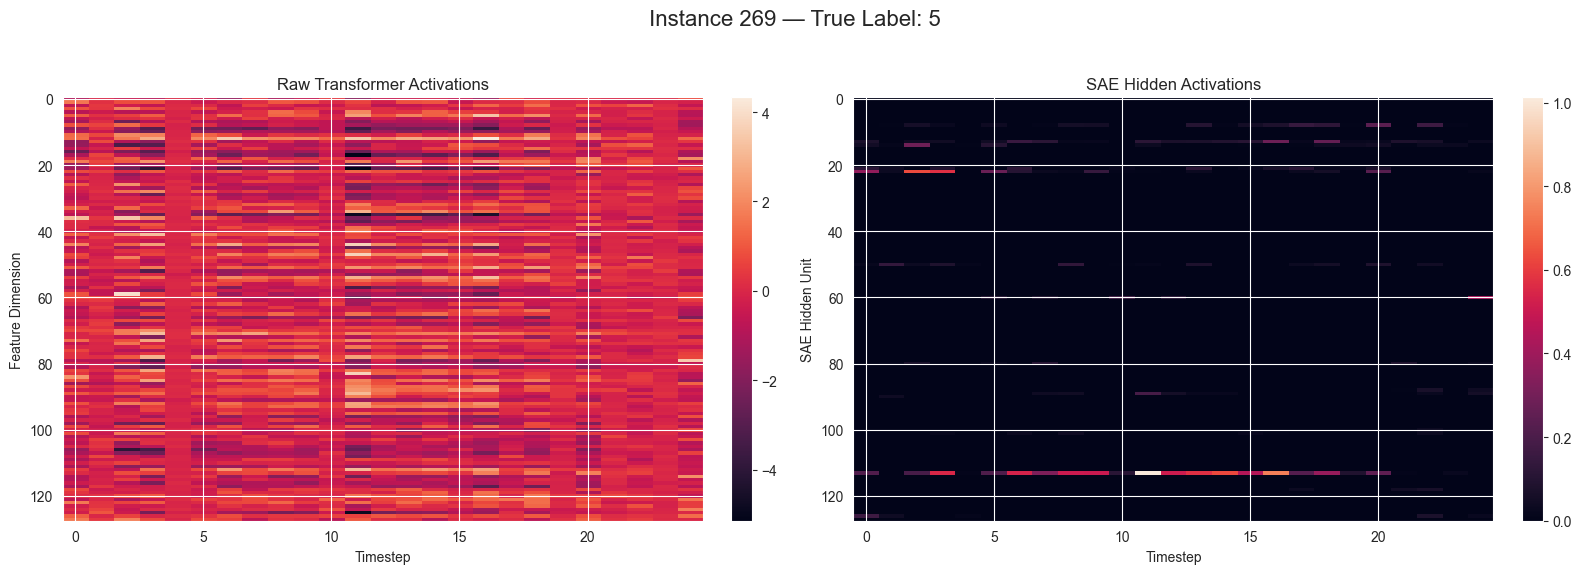

In [284]:

total_timesteps, feat_dim = ACTIVATION_TENSOR.shape
seq_len = train_batch.shape[1]
num_instances = total_timesteps // seq_len

raw_seqs = ACTIVATION_TENSOR.view(num_instances, seq_len, feat_dim)  # (N, T, D)

# compute SAE hidden codes for all timesteps, then reshape them too
sae.eval()
with torch.no_grad():
    flat_raw      = raw_seqs.view(-1, feat_dim).to(DEVICE)         # (N*T, D)
    _, flat_hidden = sae(flat_raw)                                  # (N*T, H)
    hidden_seqs    = flat_hidden.view(num_instances, seq_len, -1)   # (N, T, H)

# pick an instance to visualize
idx = 269
raw_inst    = raw_seqs[idx].T.cpu().numpy()    # shape (D, T)
hidden_inst = hidden_seqs[idx].T.cpu().numpy() # shape (H, T)
true_label  = labels[idx].item()

# plot side by side with label annotation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

im0 = axes[0].imshow(raw_inst, aspect='auto')
axes[0].set_title(f"Raw Transformer Activations")
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("Feature Dimension")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(hidden_inst, aspect='auto')
axes[1].set_title(f"SAE Hidden Activations")
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("SAE Hidden Unit")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

fig.suptitle(f"Instance {idx} — True Label: {true_label}", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


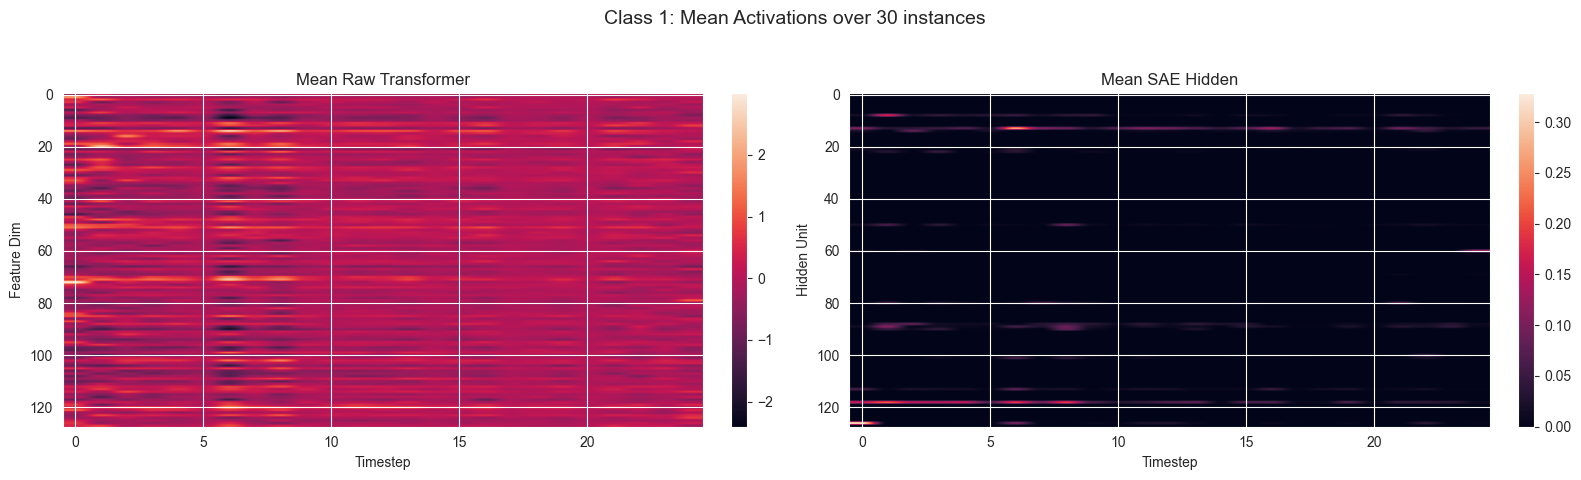

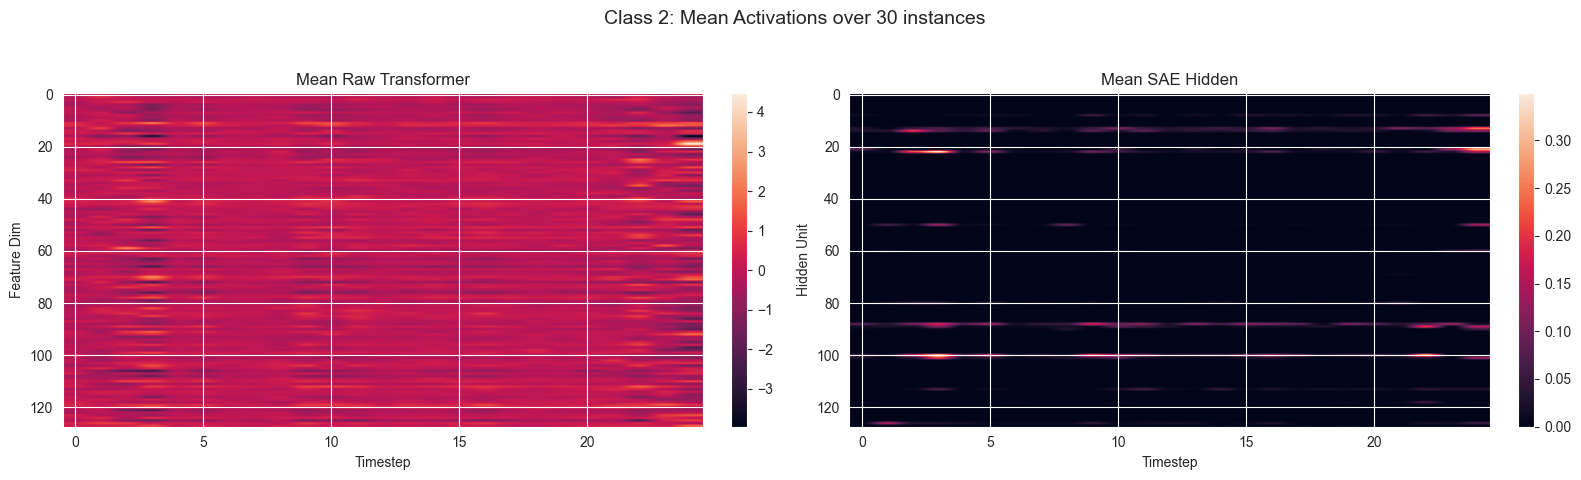

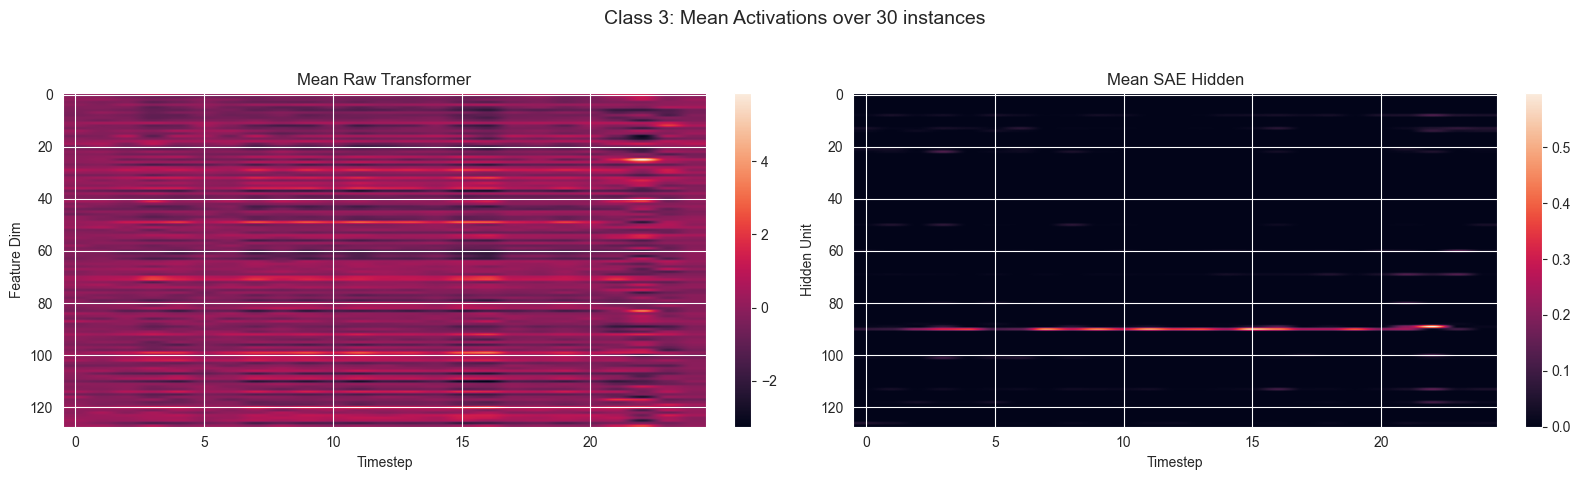

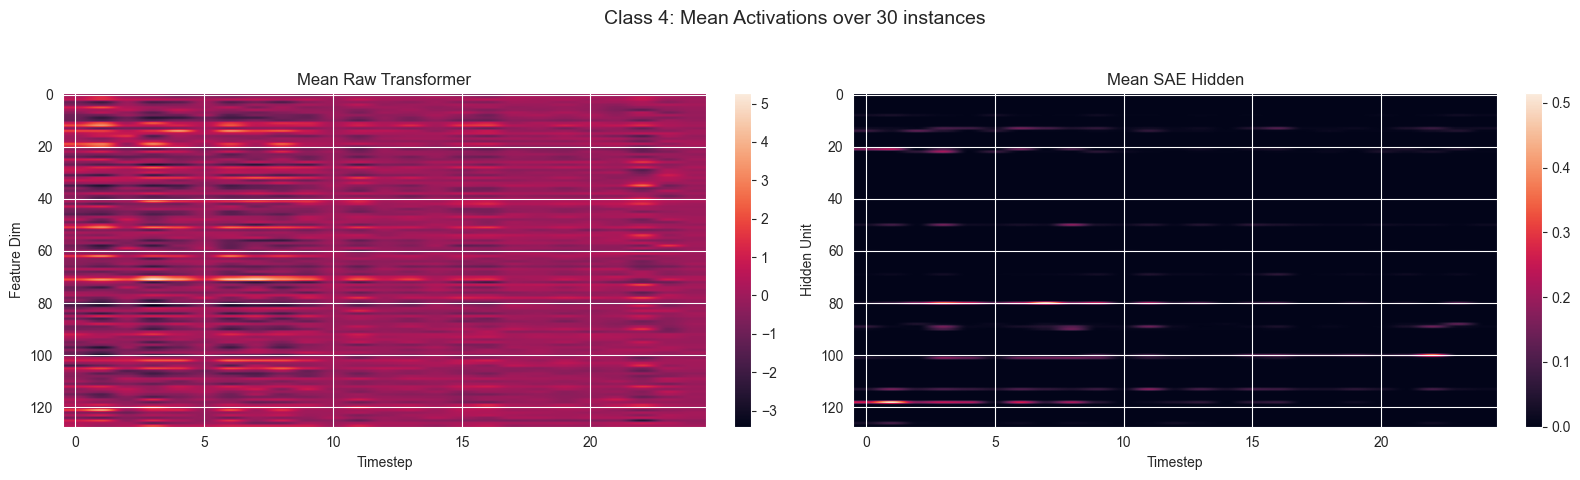

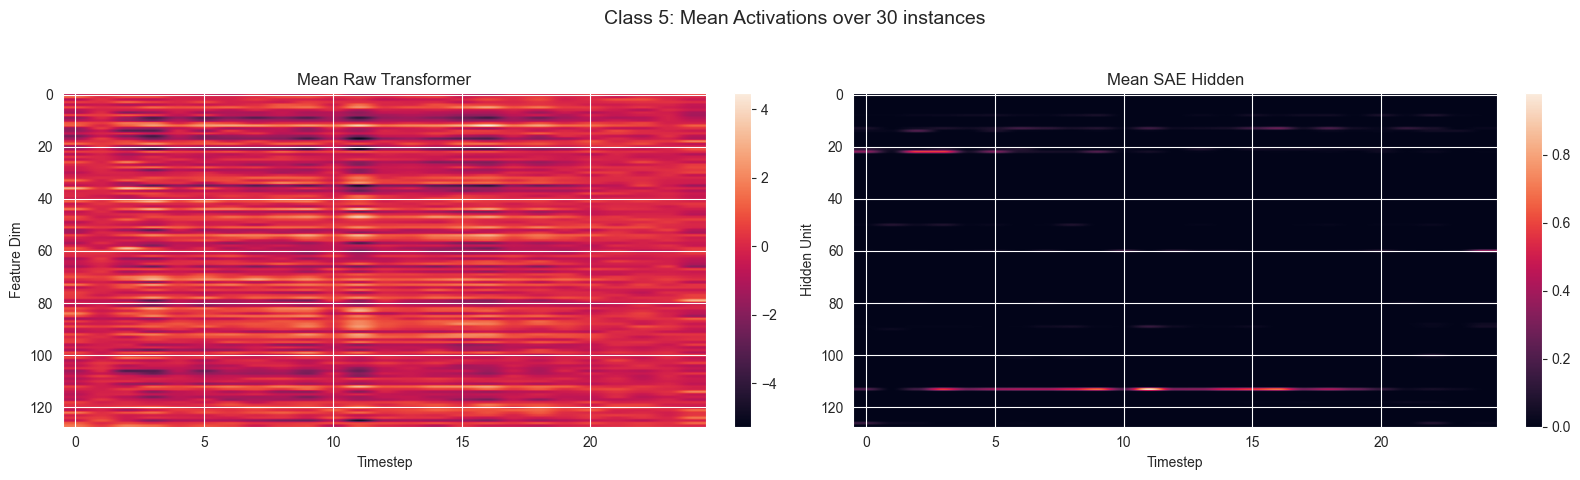

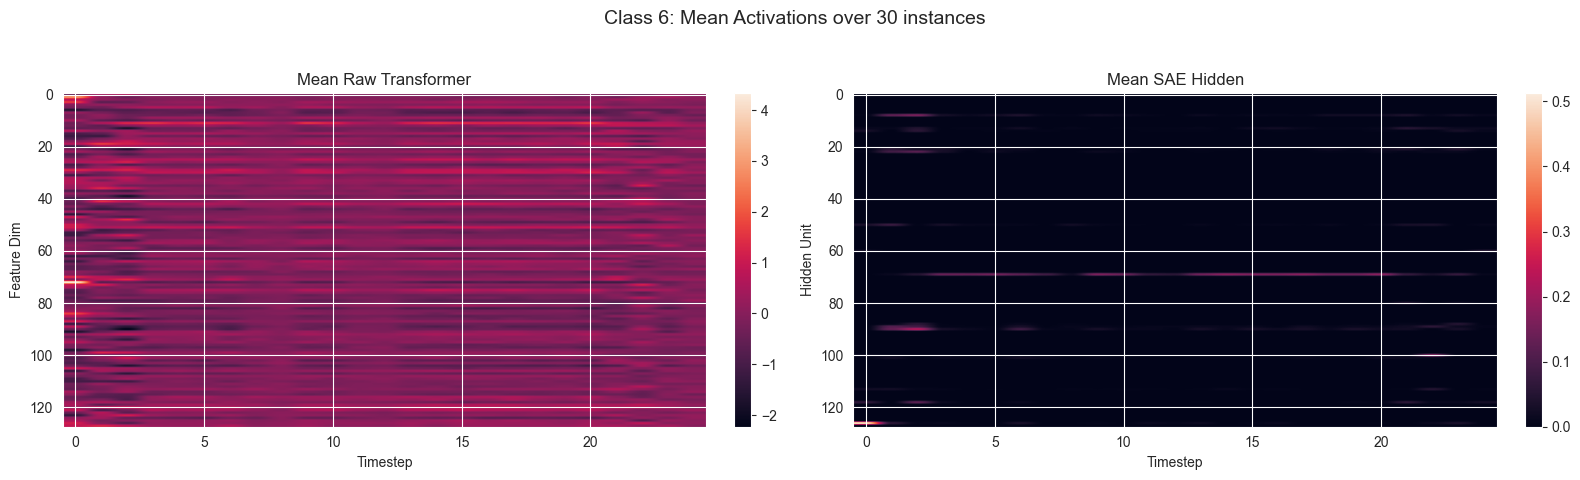

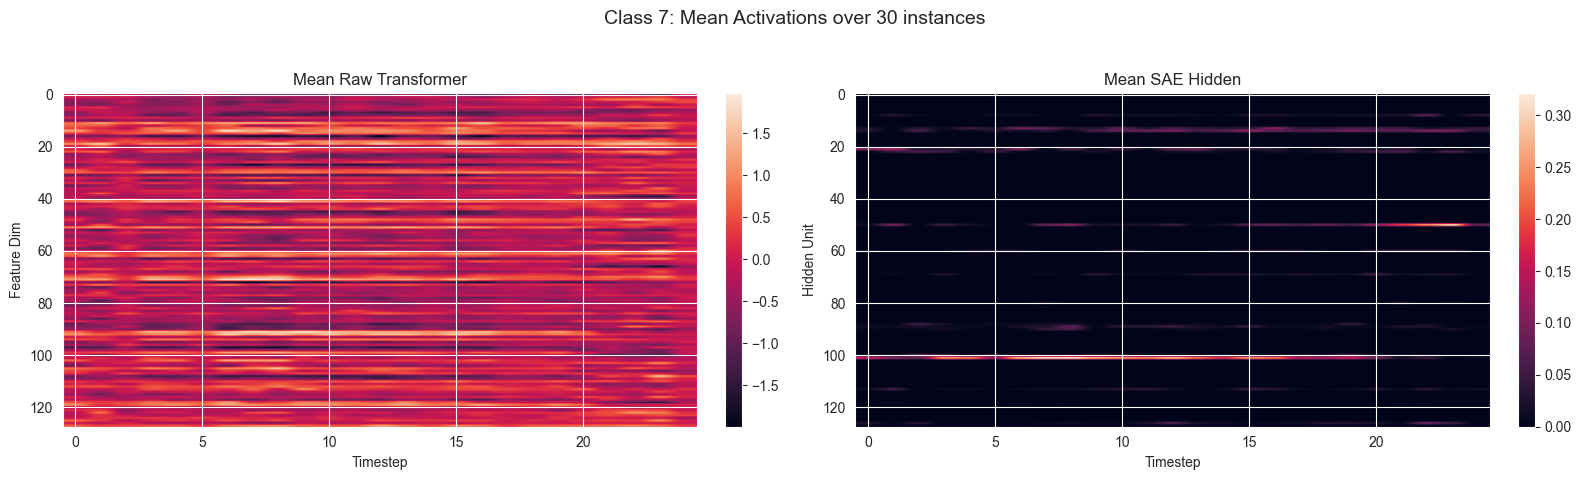

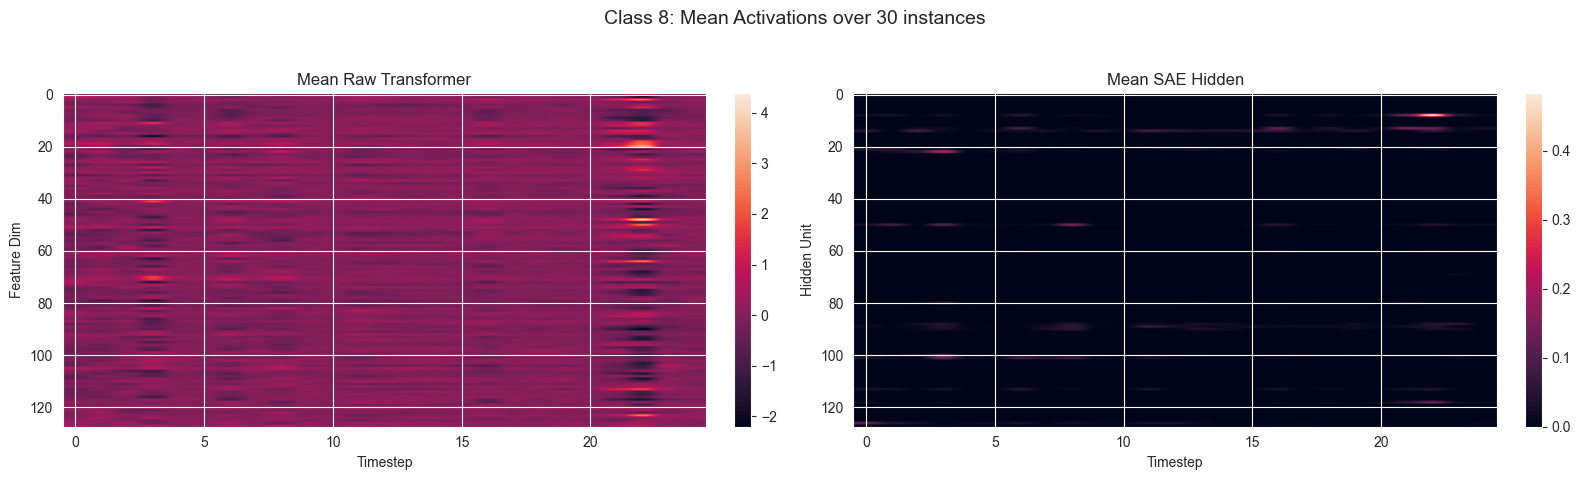

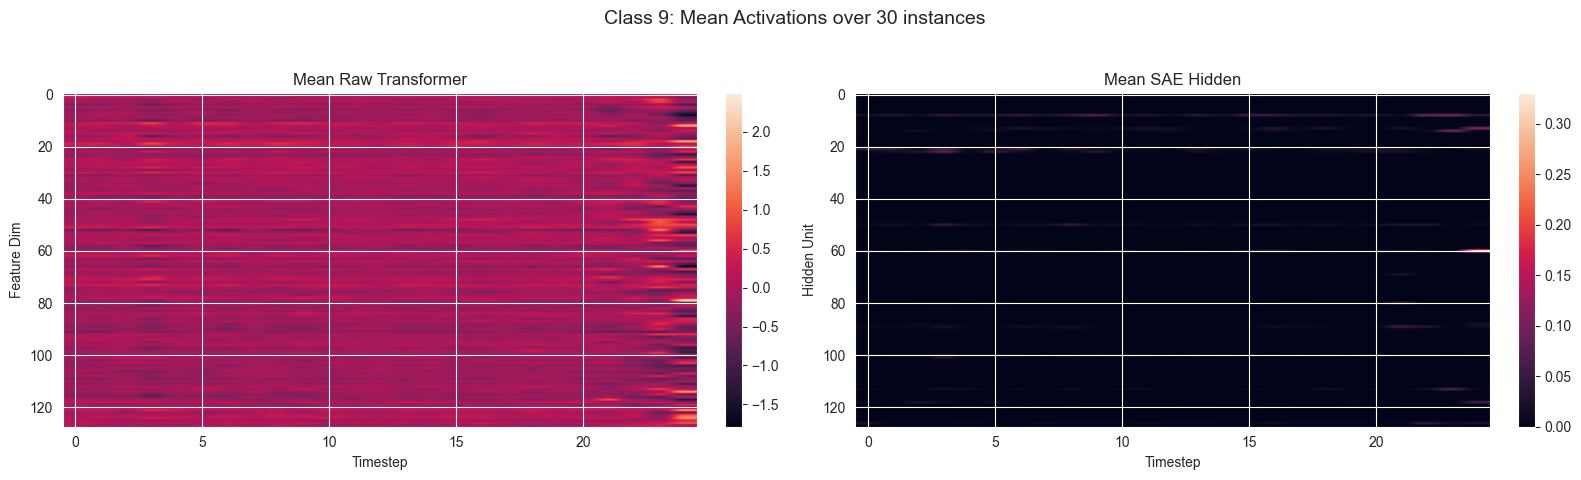

In [289]:

classes = torch.unique(labels)

for cls in classes:
    # select instances with this label
    idxs      = (labels == cls).nonzero(as_tuple=True)[0]
    raw_cls   = raw_seqs[idxs]     # (n_cls, seq_len, feat_dim)
    hid_cls   = hidden_seqs[idxs]  # (n_cls, seq_len, hidden_dim)

    # compute mean across instances  (seq_len, dim)
    mean_raw    = raw_cls.mean(dim=0).T.cpu().numpy()   # → (feature_dim, seq_len)
    mean_hidden = hid_cls.mean(dim=0).T.cpu().numpy()   # → (hidden_dim, seq_len)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f"Class {cls.item()}: Mean Activations over {len(idxs)} instances", fontsize=14)

    im0 = axes[0].imshow(mean_raw,    aspect='auto')
    axes[0].set_title("Mean Raw Transformer")
    axes[0].set_xlabel("Timestep")
    axes[0].set_ylabel("Feature Dim")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(mean_hidden, aspect='auto')
    axes[1].set_title("Mean SAE Hidden")
    axes[1].set_xlabel("Timestep")
    axes[1].set_ylabel("Hidden Unit")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [290]:
def get_topk_concepts(hidden_seqs, labels, k=5):
    topk_per_class = {}
    classes = torch.unique(labels)
    for cls in classes:
        # select all sequences of this class
        idxs = (labels == cls).nonzero(as_tuple=True)[0]
        hid_cls = hidden_seqs[idxs]            # (n_cls, T, H)

        # mean absolute activation over instances and timesteps
        mean_act = hid_cls.abs().mean(dim=(0, 1))

        # top-k feature indices
        vals, idx = torch.topk(mean_act, k=k, largest=True)
        topk_per_class[int(cls.item())] = idx.cpu().tolist()

    return topk_per_class

k = 5
topk_dict = get_topk_concepts(hidden_seqs, labels, k=k)
print(topk_dict)

Top-5 SAE concepts per class: {1: [118, 13, 8, 89, 126], 2: [100, 88, 13, 22, 14], 3: [90, 89, 8, 113, 69], 4: [80, 118, 113, 100, 101], 5: [113, 22, 13, 60, 21], 6: [69, 90, 126, 8, 89], 7: [101, 50, 14, 13, 21], 8: [8, 14, 13, 50, 101], 9: [8, 60, 21, 50, 13]}


In [293]:
def clamp_and_evaluate(
    model,
    sae,
    raw_seqs,        # (N, T, D) Tensor of transformer activations
    labels,          # (N,)         Tensor of true labels
    topk_dict,       # dict mapping class → list of top-k SAE feature indices
    clamp_value=0.0, # scalar to which we clamp
    device=DEVICE
):
    model.eval()
    sae.eval()

    seq_len    = raw_seqs.size(1)
    feat_dim   = raw_seqs.size(2)

    all_logits_orig  = []
    all_logits_clamp = []

    with torch.no_grad():
        # flatten everything once
        flat_raw = raw_seqs.view(-1, feat_dim).to(device)    # (N*T, D)
        # encode to get h
        _, flat_h = sae(flat_raw)                             # (N*T, H)
        # decode baseline reconstructions
        flat_rec_orig = sae.decoder(flat_h)                   # (N*T, D)

        # reshape back to sequence form
        rec_orig = flat_rec_orig.view(-1, seq_len, feat_dim)  # (N, T, D)

        # get original model outputs
        logits_orig = model.classifier(rec_orig)
        all_logits_orig.append(logits_orig.cpu())

        # clamp per-instance according to its true class
        flat_h_clamp = flat_h.clone()

        # for each instance i, clamp its class’s top-k units
        for i, lbl in enumerate(labels):
            k_idxs = topk_dict[int(lbl.item())]
            # determine the slice in the flattened tensor
            start = i * seq_len
            end   = (i + 1) * seq_len
            flat_h_clamp[start:end, k_idxs] = clamp_value

        # decode clamped hidden codes
        flat_rec_clamp = sae.decoder(flat_h_clamp)

        # reshape and run through model
        rec_clamp  = flat_rec_clamp.view(-1, seq_len, feat_dim)
        logits_clp = model.classifier(rec_clamp)
        all_logits_clamp.append(logits_clp.cpu())

    # concatenate
    logits_orig  = torch.cat(all_logits_orig, 0)  # (N, num_classes)
    logits_clp   = torch.cat(all_logits_clamp, 0)

    probs_orig = F.softmax(logits_orig, dim=1)
    probs_clp  = F.softmax(logits_clp,  dim=1)

    # extract true‐class probs
    N = probs_orig.size(0)
    lbls = labels.long()
    p_orig_true = probs_orig[torch.arange(N), lbls]
    p_clp_true  = probs_clp[ torch.arange(N), lbls]

    delta_p = p_clp_true - p_orig_true

    # Summary per class
    for cls, k_idxs in topk_dict.items():
        mask = (labels == cls)
        avg_drop = delta_p[mask].mean().item()
        print(f"Class {cls}: clamped top-{len(k_idxs)} units {k_idxs} → avg ΔP(true) = {avg_drop:+.3f}")

    return {
        "logits_orig": logits_orig,
        "logits_clamp": logits_clp,
        "delta_p": delta_p,
    }

Class 1: clamped top-5 units [118, 13, 8, 89, 126] → avg ΔP(true) = -0.008
Class 2: clamped top-5 units [100, 88, 13, 22, 14] → avg ΔP(true) = -0.009
Class 3: clamped top-5 units [90, 89, 8, 113, 69] → avg ΔP(true) = +0.001
Class 4: clamped top-5 units [80, 118, 113, 100, 101] → avg ΔP(true) = -0.003
Class 5: clamped top-5 units [113, 22, 13, 60, 21] → avg ΔP(true) = +0.001
Class 6: clamped top-5 units [69, 90, 126, 8, 89] → avg ΔP(true) = -0.003
Class 7: clamped top-5 units [101, 50, 14, 13, 21] → avg ΔP(true) = +0.001
Class 8: clamped top-5 units [8, 14, 13, 50, 101] → avg ΔP(true) = -0.000
Class 9: clamped top-5 units [8, 60, 21, 50, 13] → avg ΔP(true) = +0.001


In [294]:
results = clamp_and_evaluate(
    model=model,
    sae=sae,
    raw_seqs=raw_seqs,
    labels=labels,
    topk_dict=topk_dict,
    clamp_value=0.0,
)

Class 1: clamped top-5 units [118, 13, 8, 89, 126] → avg ΔP(true) = -0.008
Class 2: clamped top-5 units [100, 88, 13, 22, 14] → avg ΔP(true) = -0.009
Class 3: clamped top-5 units [90, 89, 8, 113, 69] → avg ΔP(true) = +0.001
Class 4: clamped top-5 units [80, 118, 113, 100, 101] → avg ΔP(true) = -0.003
Class 5: clamped top-5 units [113, 22, 13, 60, 21] → avg ΔP(true) = +0.001
Class 6: clamped top-5 units [69, 90, 126, 8, 89] → avg ΔP(true) = -0.003
Class 7: clamped top-5 units [101, 50, 14, 13, 21] → avg ΔP(true) = +0.001
Class 8: clamped top-5 units [8, 14, 13, 50, 101] → avg ΔP(true) = -0.000
Class 9: clamped top-5 units [8, 60, 21, 50, 13] → avg ΔP(true) = +0.001
